## Bayesian optimization of a Y-junction

**Note: the cost of running the entire notebook is larger than 10 FlexCredits.**

[Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) is a popular technique for searching and optimizing a design space. It works by building a probabilistic model, such as a [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process), to predict the outcome of a more complex objective function. Unlike other optimizers like genetic algorithms or particle swarm optimization, Bayesian optimization uses an acquisition function to select new potential solutions, focusing on areas of the design space that the Gaussian process predicts will have high objective values and high uncertainty. Over the course of the optimization, the model's uncertainty reduces, improving its accuracy as a surrogate for the true objective function. This makes Bayesian optimization a direct approach to optimization, particularly well-suited to problems with small (< 30 dimensions) and expensive-to-evaluate objective functions. 

However, as Bayesian optimization is an iterative process with many individual components, it can be challenging to design and parallelize, leading to long run times and high computational costs.  Fortunately, the Design plugin in ``Tidy3D`` includes the Bayesian optimization method ``MethodBayOpt`` which eliminates much of this complexity. Users can quickly and easily run a Bayesian optimization for complex FDTD simulations and analyze the results. Further details on Bayesian optimization and the methods used in ``Tidy3D`` are available in the open-source Python library [bayesian_optimization](https://bayesian-optimization.github.io/BayesianOptimization/basic-tour.html).

This notebook details how to perform a Bayesian optimization with the ``Tidy3D`` Design plugin for the development of a Y-junction. It is based on the work of `Zhengqi Gao, Zhengxing Zhang, and Duane S. Boning, "Automatic Synthesis of Broadband Silicon Photonic Devices via Bayesian Optimization" J. Light. Technol. 40, 7879-7892 (2022)` [DOI:10.1109/JLT.2022.3207052](https://doi.org/10.1109/JLT.2022.3207052). A detailed description of how to build a Y-junction can be found in the [Waveguide Y junction](https://www.flexcompute.com/tidy3d/examples/notebooks/YJunction/).


<img src="img/bayesian_opt_y_junction.png" width="600" alt="Schematic of the waveguide Y junction">

If you are curious about other `Design` plugin features, see these notebooks:

1. [Intro to Design Plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/)

2. [Particle Swarm Optimizer PBS](https://www.flexcompute.com/tidy3d/examples/notebooks/ParticleSwarmOptimizedPBS/)

3. [Particle Swarm Optimizer Bullseye Cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/)

4. [Genetic Algorithm Reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GeneticAlgorithmReflector/)

5. [All-Dielectric Structural Colors](https://www.flexcompute.com/tidy3d/examples/notebooks/AllDielectricStructuralColor/)

6. [Parameter Scan](https://www.flexcompute.com/tidy3d/examples/notebooks/ParameterScan/)

In [9]:
# uncomment the following line to install bayesian-optimization if it's not installed in your environment already
# pip install bayesian-optimization

import numpy as np
import matplotlib.pyplot as plt
import gdstk
from scipy.interpolate import make_interp_spline

import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.design as tdd

## Simulation Setup

The simulation is defined across the 1.5 $\mu m$ to 1.6 $\mu m$ wavelength range with 100 sampling points. The base of the model is silicon, the top of the model is silicon dioxide; we use the material constants included in the Tidy3D Tidy3D's [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html#).

In [10]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
n_wav = 100 # Number of wavelengths to sample in the range
ldas = np.linspace(1.5, 1.6, n_wav)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

si = td.material_library["cSi"]["Palik_Lossless"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

The following parameters describe the geometry of the waveguide. The optimizable design space is the junction which is split into 13 discreate segments.

In [11]:
t = 0.22  # thickness of the silicon layer
num_d = 13 # dimensional space of the design region

l_in = 1  # input waveguide length
l_junction = 2  # length of the junction
l_bend = 6  # horizontal length of the waveguide bend
h_bend = 2  # vertical offset of the waveguide bend
l_out = 1  # output waveguide length
branch_width = 0.5 # width of one Y branch
branch_sep = 0.2 # distance between y branches at the junction
inf_eff = 100  # effective infinity


The most effective way to use the Design plugin is to split the workflow into "pre" and "post" functions which can surround a call to the Tidy3D cloud that carries out the computation. This takes advantage of automated simulation batching, allowing for parallelization which saves a considerable amount of time. The pre-function returns a `Simulation`; the post-function then analyzes the corresponding `SimulationData`. Together they can be considered the fitness function (or objective function / figure of merit)  which the Bayesian optimization process is working to predict.

The ``fn_pre`` needs to take the parameters that are being optimized: these are the 13 width segements of the junction. They always input as a dictionary and can be unpacked within the function (as below) or included as keyword arguments. These parameters are used to build a Y-junction ``Simulation`` object which can be computed.

``fn_post`` then takes the ``SimulationData`` object output by the simulation and performs some analysis to return a float value which can be fed back into the Bayesian optimization to inform the probabilistic model. In this case, we extract the power passing through the Y-junction and the power reflected back to the source. These values are evaluated in a custom loss function described by ``Gao et al.`` to determine the effectiveness of the junction design. The aim of this function is to achieve a transmitted power of 0.5 through each branch, whilst driving the power reflected towards the source to zero. Note there is a minus sign in front of the output value as this loss function is a minimizing function, whilst all the optimizers in the Design plugin are built to maximize the objective function. 

In [12]:
def fn_pre(**w_params: dict) -> td.Simulation:
    """Create a Simulation of a Y splitter from a series of junction widths.
    
    Includes mode monitors to measure the power transmitted and reflected to source.
    """
    w_start = 0.5
    w_end = branch_width * 2 + branch_sep
    
    widths = [w_start] # Ensures input waveguide is included in spline for first point of junction
    widths.extend(list(w_params.values()))
    widths.append(w_end) # Ensures final point of junction smoothly converts to the branches
    
    x_junction = np.linspace(l_in, l_in + l_junction, num_d + 2)  # x coordinates of the top edge vertices
    y_junction = np.array(widths)  # y coordinates of the top edge vertices

    # pass vertices through spline and increase sampling to smooth the geometry
    new_x_junction = np.linspace(l_in, l_in + l_junction, 100)  # x coordinates of the top edge vertices
    spline = make_interp_spline(x_junction, y_junction, k=2)
    spline_yjunction = spline(new_x_junction)

    # using concatenate to include bottom edge vertices
    x_junction = np.concatenate((new_x_junction, np.flipud(new_x_junction)))
    y_junction = np.concatenate((spline_yjunction / 2, -np.flipud(spline_yjunction / 2)))

    # stacking x and y coordinates to form vertices pairs
    vertices = np.transpose(np.vstack((x_junction, y_junction)))

    junction = td.Structure(
        geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t)), medium=si
    )

    x_start = l_in + l_junction # x coordinate of the starting point of the waveguide bends

    x_bend = np.linspace(x_start, x_start + l_bend, 100)  # x coordinates of the top edge vertices

    y_bend = (
        (x_bend - x_start) * h_bend / l_bend
        - h_bend * np.sin(2 * np.pi * (x_bend - x_start) / l_bend) / (np.pi * 2)
        + w_end / 2
        - w_start / 2
    )  # y coordinates of the top edge vertices

    # adding the last point to include the straight waveguide at the output
    x_bend = np.append(x_bend, inf_eff)
    y_bend = np.append(y_bend, y_bend[-1])

    # add path to the cell
    cell = gdstk.Cell("bends")
    cell.add(gdstk.FlexPath(x_bend + 1j * y_bend, branch_width, layer=1, datatype=0))  # top waveguide bend
    cell.add(gdstk.FlexPath(x_bend - 1j * y_bend, branch_width, layer=1, datatype=0))  # bottom waveguide bend

    # define top waveguide bend structure
    wg_bend_1 = td.Structure(
        geometry=td.PolySlab.from_gds(
            cell,
            gds_layer=1,
            axis=2,
            slab_bounds=(0, t),
        )[0],
        medium=si,
    )

    # define bottom waveguide bend structure
    wg_bend_2 = td.Structure(
        geometry=td.PolySlab.from_gds(
            cell,
            gds_layer=1,
            axis=2,
            slab_bounds=(0, t),
        )[1],
        medium=si,
    )

    # straight input waveguide
    wg_in = td.Structure(
        geometry=td.Box.from_bounds(rmin=(-inf_eff, -w_start / 2, 0), rmax=(l_in, w_start / 2, t)),
        medium=si,
    )

    # the entire model is the collection of all structures defined so far
    model_structure = [wg_in, junction, wg_bend_1, wg_bend_2]

    Lx = l_in + l_junction + l_out + l_bend  # simulation domain size in x direction
    Ly = w_end + 2 * h_bend + 1.5 * lda0  # simulation domain size in y direction
    Lz = 10 * t  # simulation domain size in z direction
    sim_size = (Lx, Ly, Lz)

    # add a mode source as excitation
    mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
    mode_source = td.ModeSource(
        center=(l_in / 2, 0, t / 2),
        size=(0, 4 * w_start, 6 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
    )

    # add a mode monitor to measure transmission at the output waveguide
    mode_monitor_11 = td.ModeMonitor(
        center=(l_in / 3 , 0, t / 2),
        size=(0, 4 * w_start, 6 * t),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode_11",
    )
    
    mode_monitor_12 = td.ModeMonitor(
        center=(l_in + l_junction + l_bend + l_out / 2, w_end / 2 - w_start / 2 + h_bend, t / 2),
        size=(0, 4 * w_start, 6 * t),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode_12",
    )

    # add a field monitor to visualize field distribution at z=t/2
    field_monitor = td.FieldMonitor(
        center=(0, 0, t / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
    )

    run_time = 5e-13  # simulation run time

    # construct simulation
    sim = td.Simulation(
        center=(Lx / 2, 0, 0),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=model_structure,
        sources=[mode_source],
        monitors=[mode_monitor_11, mode_monitor_12, field_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=sio2,
    )
    
    return sim

def fn_post(sim_data: td.SimulationData) -> float:
    """Calculate the loss function from the power at the mode monitors in the SimulationData."""
    # Calculate the power reflected back to source and transmitted to one branch
    power_reflected = np.squeeze(np.abs(sim_data["mode_11"].amps.sel(direction="-", mode_index=0)) ** 2)
    power_transmitted = np.squeeze(np.abs(sim_data["mode_12"].amps.sel(direction="+", mode_index=0)) ** 2)
    
    # Loss function proposed by Gao et al. which takes advantage of branch symmetry
    loss_fn = 1 / 3 * n_wav * np.sum(power_reflected ** 2 + 2 * (power_transmitted - 0.5) ** 2)
    output = -float(loss_fn.values) # Negative value as this is a minimizing loss function
    
    return output

We can quickly check that out ``fn_pre`` is working correctly by passing a set of potential ``test_params`` and plotting the result. Note that the gap between the `Polyslab` junction and the branches is a plotting artifact and doesn't exist in the `Simulation`.

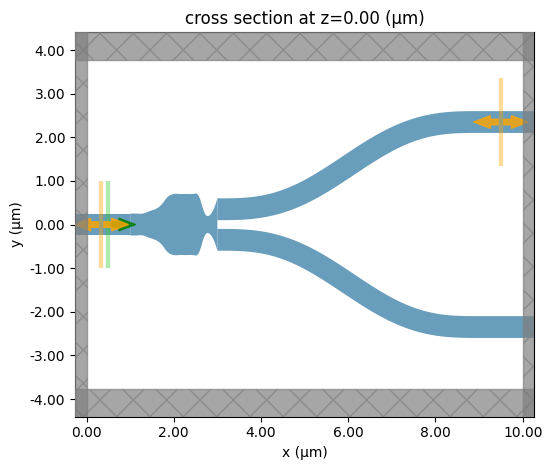

In [13]:
test_params = {
    "w1": 0.5,
    "w2": 0.5,
    "w3": 0.6,
    "w4": 0.7,
    "w5": 0.9,
    "w6": 1.26,
    "w7": 1.4,
    "w8": 1.4,
    "w9": 1.4,
    "w10": 1.4,
    "w11": 1.31,
    "w12": 0.5,
    "w13": 0.5,
}
sim = fn_pre(**test_params)
sim.plot(z=0)
plt.show()

The set up for the Bayesian optimization can be easily replicated with the ``Method`` arguments. We don't have the ``lcb`` (lower confidence bound) acquisition function used in the paper available to us, but by making our loss function negative and using the ``ucb`` (upper confidence bound) acquisition we achieve the same optimizer design. We set the seed to keep the results consistant between runs, but this isn't necessary for most optimization problems.

A simple set ``Parameters`` are created with generic names, as we don't access them by keywords, and spans as we only need to vary float values across a small range.

The ``Method`` and ``Parameters`` are then passed to a ``DesignSpace`` which controls all we need to run the Bayesian optimization.

In [14]:
method = tdd.MethodBayOpt(
    initial_iter=30,
    n_iter=70,
    acq_func='ucb',
    kappa=0.3,
    seed=1,
)

parameters = [tdd.ParameterFloat(name=f"w_{i}", span=(0.5, 1.6)) for i in range(num_d)]

design_space = tdd.DesignSpace(method=method, parameters=parameters, task_name="bay_opt_notebook", path_dir="./data")

It is then very easy to the launch this optimization with ``design_space.run``. This launches an initial batch of 30 simulations with randomly generated solutions, followed by sequential computation of 70 simulations with the optimizer suggesting potential solutions that have good potential and effectively explore the design space. The total of 100 simulations takes around 90 minutes to compute. Once complete the results can be stored in a ``Pandas`` dataframe for analysis

In [15]:
results = design_space.run(fn_pre, fn_post, verbose=True)
df = results.to_dataframe()

16:16:40 BST Running 30 Simulations

16:22:49 BST Best Fit from Initial Solutions: -181.231                          
             

             Running 1 Simulations

16:24:34 BST Running 1 Simulations

16:27:29 BST Running 1 Simulations

16:28:38 BST Latest Best Fit on Iter 2: -150.43                                 
             

             Running 1 Simulations

16:30:17 BST Latest Best Fit on Iter 3: -134.777                                
             

16:30:18 BST Running 1 Simulations

16:32:02 BST Latest Best Fit on Iter 4: -122.768                                
             

             Running 1 Simulations

16:33:18 BST Running 1 Simulations

16:34:22 BST Latest Best Fit on Iter 6: -81.616                                 
             

             Running 1 Simulations

16:36:03 BST Running 1 Simulations

16:37:49 BST Running 1 Simulations

16:38:51 BST Running 1 Simulations

16:40:35 BST Running 1 Simulations

16:42:32 BST Latest Best Fit on Iter 11: -67.751                                
             

16:42:33 BST Running 1 Simulations

16:43:39 BST Running 1 Simulations

16:44:48 BST Running 1 Simulations

16:46:35 BST Running 1 Simulations

16:48:26 BST Running 1 Simulations

16:52:52 BST Latest Best Fit on Iter 16: -50.891                                
             

             Running 1 Simulations

16:54:05 BST Running 1 Simulations

16:55:12 BST Running 1 Simulations

16:56:10 BST Latest Best Fit on Iter 19: -49.99                                 
             

16:56:12 BST Running 1 Simulations

16:57:20 BST Latest Best Fit on Iter 20: -41.954                                
             

             Running 1 Simulations

16:59:07 BST Latest Best Fit on Iter 21: -39.001                                
             

             Running 1 Simulations

17:00:49 BST Running 1 Simulations

17:02:42 BST Latest Best Fit on Iter 23: -33.742                                
             

             Running 1 Simulations

17:03:54 BST Latest Best Fit on Iter 24: -29.549                                
             

             Running 1 Simulations

17:04:57 BST Latest Best Fit on Iter 25: -19.056                                
             

17:04:58 BST Running 1 Simulations

17:06:40 BST Running 1 Simulations

17:08:20 BST Running 1 Simulations

17:10:06 BST Running 1 Simulations

17:11:14 BST Latest Best Fit on Iter 29: -18.09                                 
             

17:11:15 BST Running 1 Simulations

17:12:19 BST Latest Best Fit on Iter 30: -10.95                                 
             

17:12:20 BST Running 1 Simulations

17:14:05 BST Running 1 Simulations

17:15:53 BST Latest Best Fit on Iter 32: -9.102                                 
             

17:15:54 BST Running 1 Simulations

17:26:54 BST Running 1 Simulations

17:28:43 BST Running 1 Simulations

17:30:29 BST Running 1 Simulations

17:32:08 BST Latest Best Fit on Iter 36: -8.663                                 
             

             Running 1 Simulations

17:33:20 BST Running 1 Simulations

17:34:16 BST Running 1 Simulations

17:35:26 BST Latest Best Fit on Iter 39: -7.726                                 
             

             Running 1 Simulations

17:36:37 BST Latest Best Fit on Iter 40: -7.207                                 
             

17:36:38 BST Running 1 Simulations

17:37:38 BST Running 1 Simulations

17:38:39 BST Latest Best Fit on Iter 42: -6.661                                 
             

             Running 1 Simulations

17:39:45 BST Running 1 Simulations

17:40:54 BST Latest Best Fit on Iter 44: -5.694                                 
             

             Running 1 Simulations

17:42:18 BST Latest Best Fit on Iter 45: -5.542                                 
             

17:42:19 BST Running 1 Simulations

17:43:22 BST Running 1 Simulations

17:44:27 BST Running 1 Simulations

17:45:36 BST Running 1 Simulations

17:46:45 BST Running 1 Simulations

17:49:44 BST Latest Best Fit on Iter 50: -5.487                                 
             

17:49:45 BST Running 1 Simulations

17:54:30 BST Latest Best Fit on Iter 51: -4.927                                 
             

             Running 1 Simulations

17:56:09 BST Running 1 Simulations

17:58:01 BST Running 1 Simulations

17:58:57 BST Latest Best Fit on Iter 54: -4.893                                 
             

17:58:58 BST Running 1 Simulations

18:00:01 BST Running 1 Simulations

18:01:08 BST Running 1 Simulations

18:02:53 BST Latest Best Fit on Iter 57: -4.86                                  
             

18:02:55 BST Running 1 Simulations

18:04:37 BST Running 1 Simulations

18:06:21 BST Latest Best Fit on Iter 59: -4.83                                  
             

18:06:23 BST Running 1 Simulations

18:07:55 BST Running 1 Simulations

18:09:27 BST Latest Best Fit on Iter 61: -4.777                                 
             

             Running 1 Simulations

18:10:38 BST Latest Best Fit on Iter 62: -4.737                                 
             

18:10:39 BST Running 1 Simulations

18:11:33 BST Latest Best Fit on Iter 63: -4.699                                 
             

18:11:34 BST Running 1 Simulations

18:13:08 BST Latest Best Fit on Iter 64: -4.656                                 
             

18:13:09 BST Running 1 Simulations

18:14:21 BST Running 1 Simulations

18:15:31 BST Latest Best Fit on Iter 66: -4.587                                 
             

18:15:32 BST Running 1 Simulations

18:16:33 BST Latest Best Fit on Iter 67: -4.538                                 
             

             Running 1 Simulations

18:18:10 BST Latest Best Fit on Iter 68: -4.499                                 
             

18:18:11 BST Running 1 Simulations

18:19:47 BST Latest Best Fit on Iter 69: -4.406                                 
             

             Best Result: -4.4055562604894485                                   
             Best Parameters: w_0: 0.5931301204038487 w_1: 0.5 w_10:            
             0.5903932922556919 w_11: 0.5 w_12: 1.3472697086120091 w_2:         
             1.1303513561201977 w_3: 1.6 w_4: 1.409963655095437 w_5:            
             1.3575099556878945 w_6: 1.4521481413205992 w_7: 1.2184433257470613 
             w_8: 1.6 w_9: 1.078173871888387                                    
             

## Results

The best result can be extracted directly from the optimizer object. Plotting this, we see what the optimizer has returned as the optimized structure for this design of Y-junction.

Best fitness: -4.4055562604894485


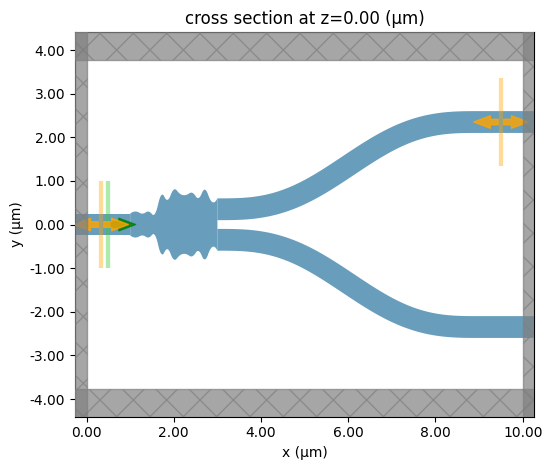

In [16]:
best_params = results.optimizer.max["params"]
print(f"Best fitness: {results.optimizer.max['target']}")
sim = fn_pre(**best_params)
sim.plot(z=0)
plt.show()

We can then create a plot to evaluate if the Bayesian optimization has converged on a fitness value. The first 30 iterations are from the random initialisation, so the fitness values are expected to be more varied. The fitness has converged before the end of the remaining 70 iterations; an early stop criteria could have been included to finish the optimization sooner.

<Axes: xlabel='Simulation Number', ylabel='Fitness'>

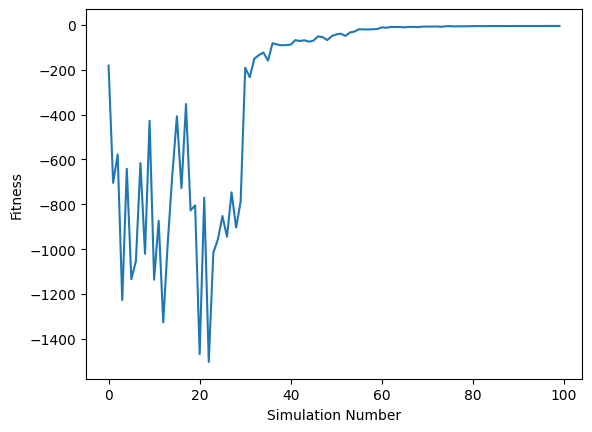

In [17]:
df["output"].plot(xlabel="Simulation Number", ylabel="Fitness")

The mean power at the reflected and transmitted monitors can be calculated and compared to the paper from ``Gao et al.``

In [18]:
idx_best_result = df["output"].idxmax()
best_sim_filename = results.task_paths[idx_best_result]
best_sim = td.SimulationData.from_file(best_sim_filename)

power_reflected = np.array(np.squeeze(np.abs(best_sim["mode_11"].amps.sel(direction="-", mode_index=0)) ** 2)).mean()
power_transmitted = np.array(np.squeeze(np.abs(best_sim["mode_12"].amps.sel(direction="+", mode_index=0)) ** 2)).mean()

print(f"Mean Reflected Power: {round(power_reflected, 3)} (Paper: 0.004)")
print(f"Mean Transmitted Power: {round(power_transmitted, 3)} (Paper: 0.460)")


Mean Reflected Power: 0.003 (Paper: 0.004)
Mean Transmitted Power: 0.475 (Paper: 0.460)


## Final Optimized Design

Finally, we can simulate the optimium solution with an additional `FieldMonitor` to visualise the field distribution throughout the splitter.

In [19]:
final_sim = fn_pre(**best_params)

# Define a field monitor to help visualize the field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

mode_12 = final_sim.monitors[1]

final_sim = final_sim.copy(
    update={"monitors": (field_monitor, mode_12)}
)

final_sim_data = web.run(final_sim, task_name="BO_notebook_final_sim")

18:52:56 BST Created task 'BO_notebook_final_sim' with task_id                  
             'fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=872774;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=835121;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\taskId]8;;\]8;id=872774;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\=]8;;\]8;id=884777;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\fdve]8;;\]8;id=872774;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\-2c35ea58-cda]8;;\
             ]8;id=872774;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\7-48dd-9543-fbbb972b906c']8;;\.

Output()

18:52:59 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:53:11 BST status = preprocess

18:53:13 BST Maximum FlexCredit cost: 0.112. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

18:53:14 BST running solver

Output()

18:53:54 BST early shutoff detected at 76%, exiting.

18:53:55 BST status = postprocess

Output()

18:53:57 BST status = success

18:53:58 BST View simulation result at                                          
             ]8;id=897911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=202944;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\taskId]8;;\]8;id=897911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\=]8;;\]8;id=66153;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\fdve]8;;\]8;id=897911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\-2c35ea58-cda]8;;\
             ]8;id=897911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c35ea58-cda7-48dd-9543-fbbb972b906c\7-48dd-9543-fbbb972b906c']8;;\.

Output()

18:54:01 BST loading simulation from simulation_data.hdf5

Plotting the field shows how it splits evenly between each branch.

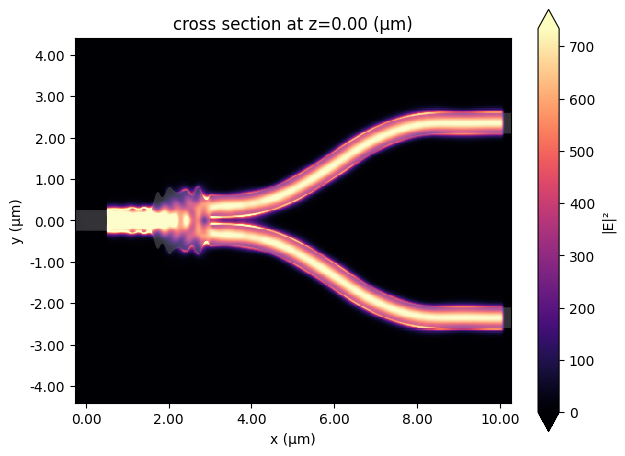

In [20]:
final_sim_data.plot_field("field", "E", "abs^2")
plt.show()

And we can visualise how the power transmitted varies over the frequency range. 

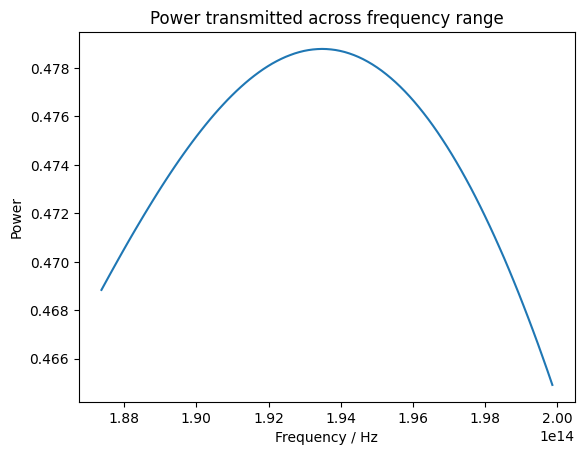

In [21]:
power_transmitted = np.squeeze(np.abs(final_sim_data["mode_12"].amps.sel(direction="+", mode_index=0)) ** 2)
plt.plot(freqs, power_transmitted)
plt.title("Power transmitted across frequency range")
plt.xlabel("Frequency / Hz")
plt.ylabel("Power")
plt.show()

## Conclusion

Through comparison of the junction geometry and the transmitted and reflected power, we can show that these results closely follow the results published by ``Gao et al.`` for the design of a Y-junction. This notebook demonstrates how to carry out Bayesian optimization with the Design plugin, and can be adapted to other usecases.

Other `Design` plugin notebooks:

1. [Intro to Design Plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/)

2. [Particle Swarm Optimizer PBS](https://www.flexcompute.com/tidy3d/examples/notebooks/ParticleSwarmOptimizedPBS/)

3. [Particle Swarm Optimizer Bullseye Cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/)

4. [Genetic Algorithm Reflector](https://www.flexcompute.com/tidy3d/examples/notebooks/GeneticAlgorithmReflector/)

5. [All-Dielectric Structural Colors](https://www.flexcompute.com/tidy3d/examples/notebooks/AllDielectricStructuralColor/)

6. [Parameter Scan](https://www.flexcompute.com/tidy3d/examples/notebooks/ParameterScan/)